In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sub import estimate

importlib.reload(estimate)

plt.rcParams["figure.figsize"] = (20, 12)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
# LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"
LOG_FILE_PATH = "../trials/4_1_51_pdr.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [18]:
from sub import pdr

importlib.reload(pdr)

data = pdr.read_log_data(LOG_FILE_PATH)
acc_df, gyro_df, mgf_df, ground_truth_df, blescans_df = pdr.convert_to_dataframes(data)

dict_keys(['ACCE', 'MAGN', 'GYRO', 'POS3'])
         ts         x         y         z
0  0.003125  9.433155 -0.861913  2.097321
1  0.013075  9.452309 -0.871489  2.183512
2  0.023024  9.442732 -0.881066  2.202666
3  0.032974  9.433155 -0.871489  2.240973
4  0.042923  9.500193 -0.852336  2.240973


In [4]:
from sub import pdr

importlib.reload(pdr)

map_dict = pdr.load_floor_maps(FLOOR_NAMES, "../gis/")
edit_map_dict = pdr.load_floor_maps(FLOOR_NAMES, "../gis/", "_edited")
floor_name = ground_truth_df.floor[0]

dx = 0.01
dy = 0.01

In [5]:
from scipy.signal import find_peaks

acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)
acc_df["rolling_norm"] = acc_df["norm"].rolling(10).mean()

peaks, _ = find_peaks(acc_df["rolling_norm"], height=12, distance=10)

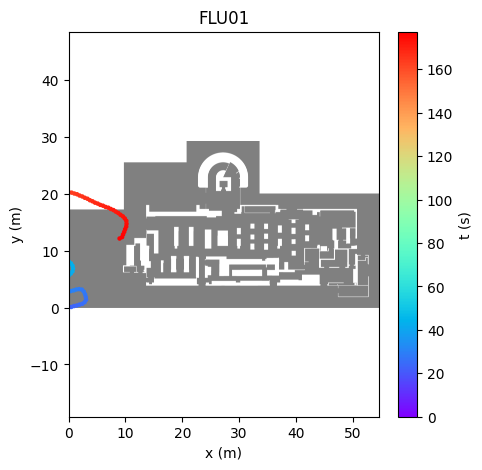

In [6]:
from sub import pdr, utils

importlib.reload(utils)
importlib.reload(pdr)

trajectory_df, cumulative_displacement_angle = pdr.estimate_trajectory(
    acc_df,
    gyro_df,
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    trajectory_df,
    display_map=True,
)

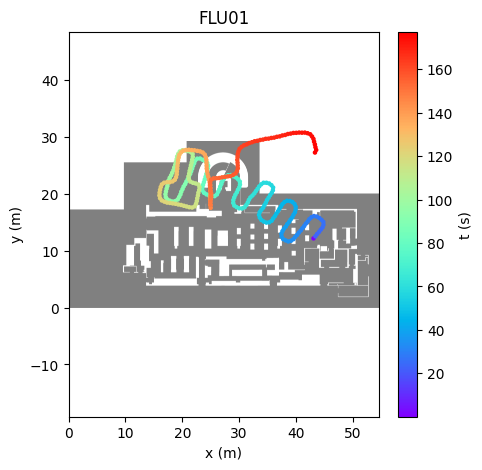

In [7]:
from sub import utils

importlib.reload(utils)

initial_direction = utils.extract_rotation(
    [
        ground_truth_df.q0[0],
        ground_truth_df.q1[0],
        ground_truth_df.q2[0],
        ground_truth_df.q3[0],
    ],
)

angle_df = estimate.convert_to_angle_from_gyro(gyro_df)
angle_df_in_step_timing = estimate.convert_to_peek_angle(gyro_df, acc_df, peaks)
diff = angle_df_in_step_timing["x"][0] - initial_direction
rotate_by_first_half_angle = pd.DataFrame(
    {
        "ts": angle_df["ts"],
        "x": angle_df["x"] - diff,
    },
)

rotate_by_first_half_angle_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        rotate_by_first_half_angle,
        acc_df,
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["%time"][0],
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    rotate_by_first_half_angle_displacement,
)

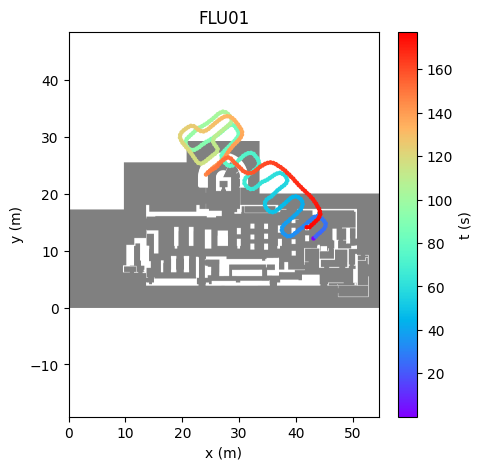

In [8]:
from sub import drift, utils

importlib.reload(drift)
importlib.reload(utils)


first_time_remove_drift_angle, first_time_remove_drift_angle_displacement = (
    drift.remove_drift_in_angle_df(
        acc_df,
        rotate_by_first_half_angle,
        ground_truth_df,
    )
)


# マップの描画
utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    first_time_remove_drift_angle_displacement,
    display_map=True,
)

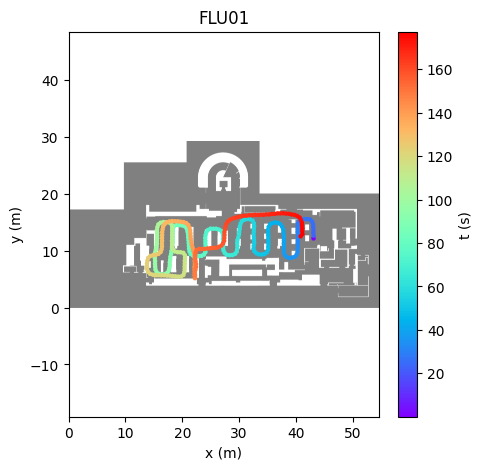

In [9]:
# refactored code

from sub import estimate, pdr_direction, utils

importlib.reload(pdr_direction)
importlib.reload(utils)
importlib.reload(estimate)

straight_angle, straight_angle_displacement = (
    pdr_direction.rotate_trajectory_to_optimal_alignment(
        acc_df,
        first_time_remove_drift_angle,
        ground_truth_df,
        edit_map_dict,
        floor_name,
        dx,
        dy,
    )
)


utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    straight_angle_displacement,
    display_map=True,
)

水平成分と垂直成分の色を変更するコード


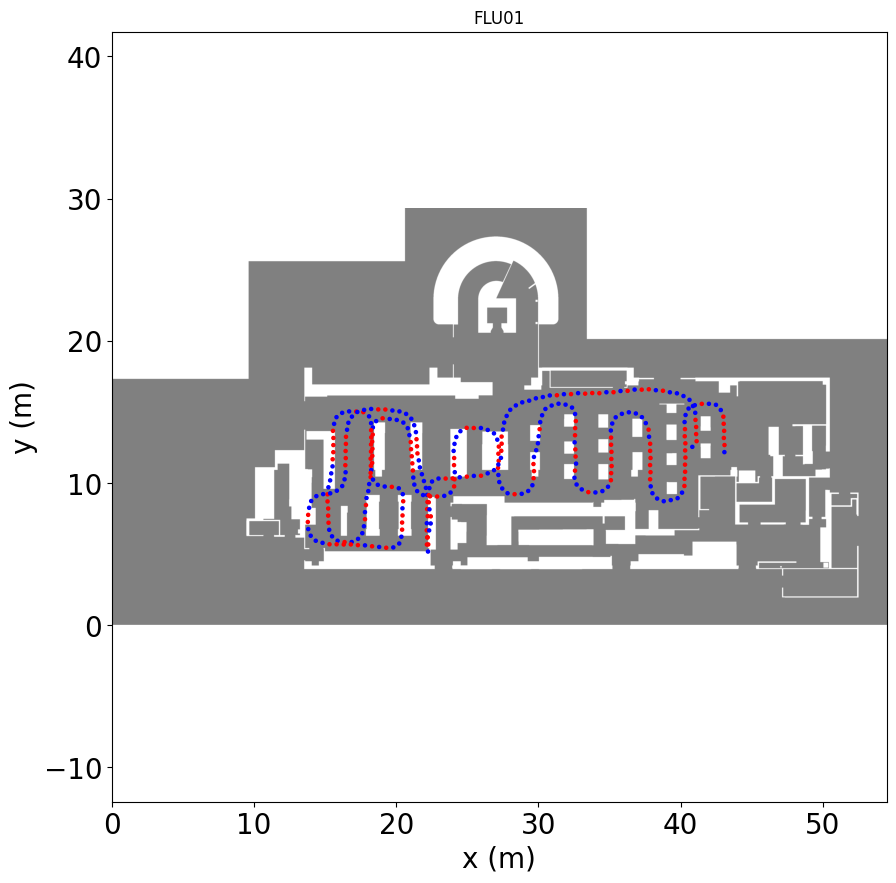

In [10]:
estimate.plot_map(map_dict, floor_name, dx, dy)
colors = straight_angle_displacement["is_vertical_or_horizontal"].map(
    {True: "r", False: "b", np.nan: "b"},
)

plt.scatter(
    straight_angle_displacement.x_displacement,
    straight_angle_displacement.y_displacement,
    c=colors,
    s=5,
)

plt.tick_params(labelsize=20)
plt.xlabel("x (m)", fontsize=20)
plt.ylabel("y (m)", fontsize=20)

plt.show()

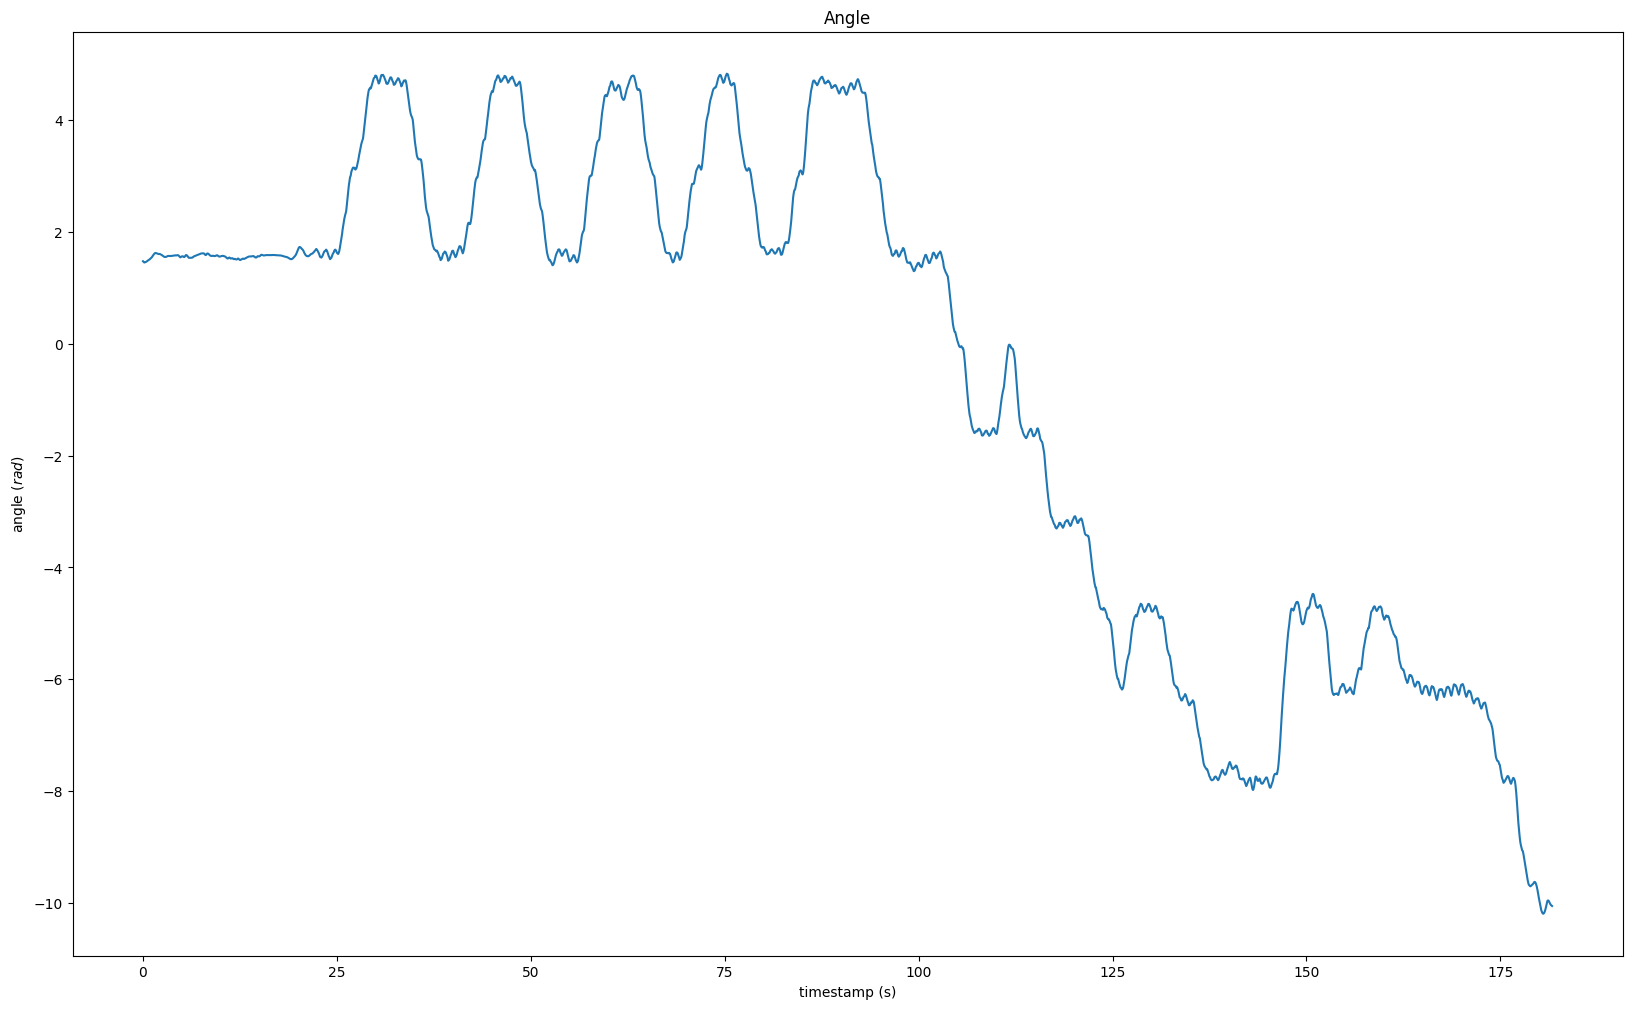

In [11]:
plt.plot(straight_angle.ts, straight_angle["x"])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

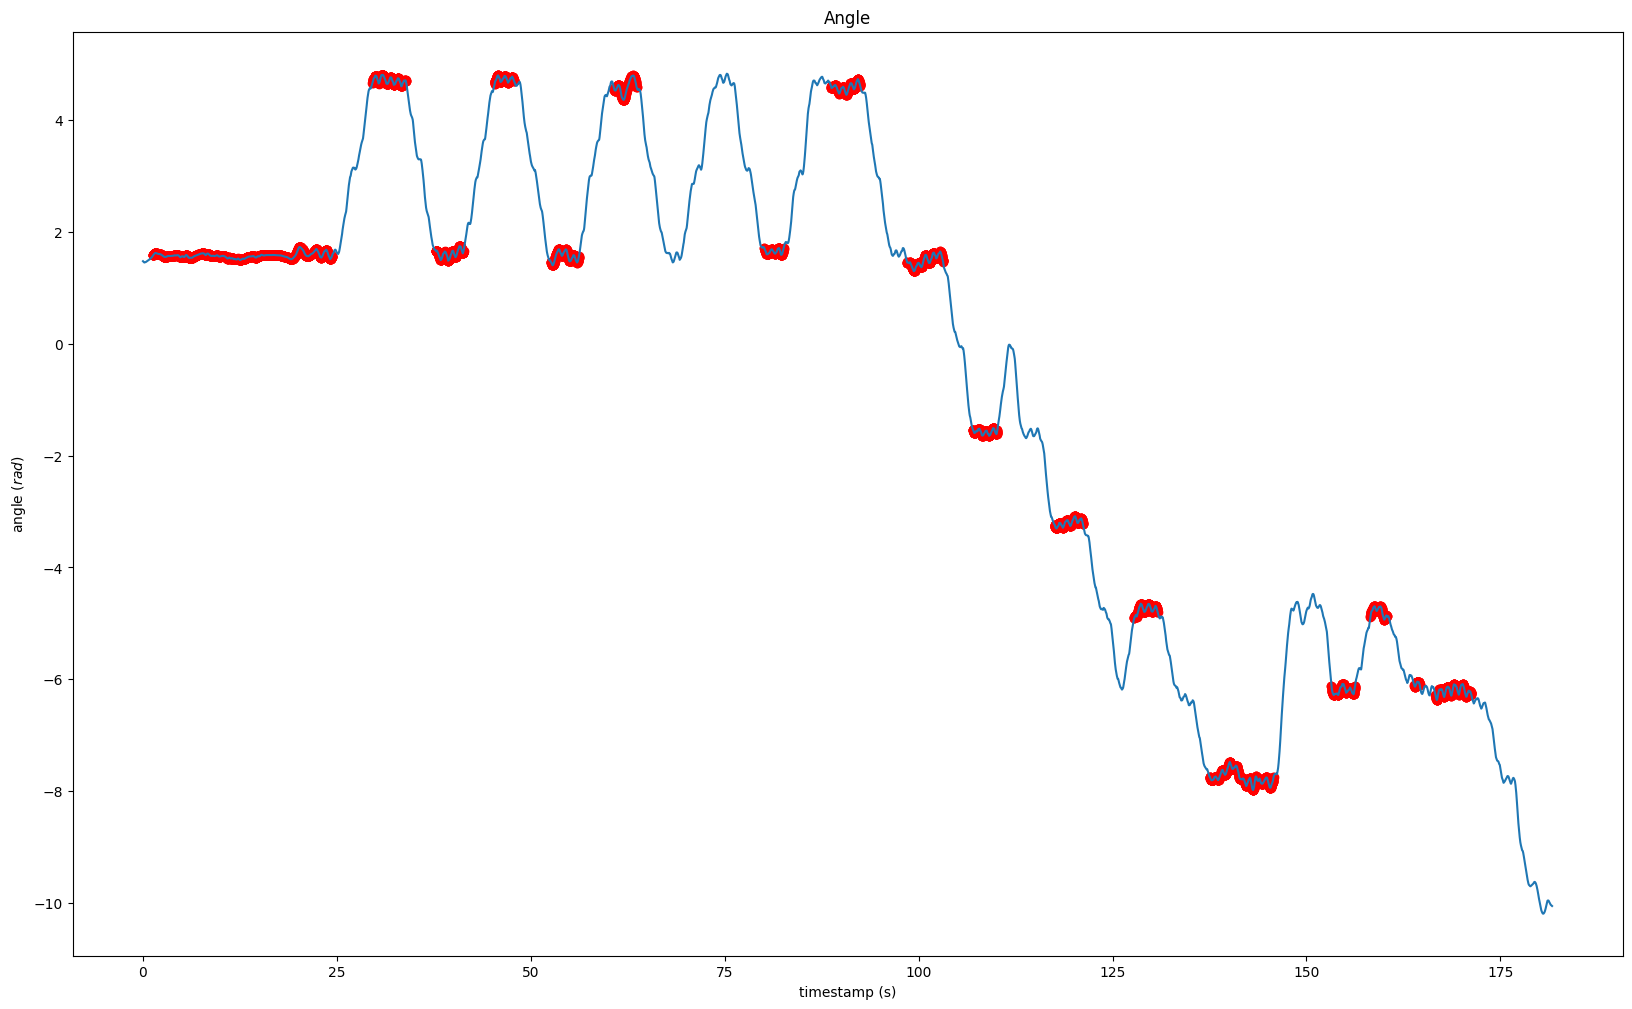

In [12]:
# 安定歩行区間を設けて，その区間に入っている場合角度を補正する
# 安定歩行区間とは，角度が一定範囲内に数秒間収まっている区間のこと
# 角度範囲は+-20度とする，数秒間は5秒とする


def extract_stable_angle(
    angle_df: pd.DataFrame,
    stable_angle_range: float,
    stable_time: float,
) -> pd.DataFrame:
    stable_angle_df = pd.DataFrame()
    stable_angle_df["ts"] = angle_df["ts"]
    stable_angle_df["x"] = angle_df["x"]
    stable_angle_df["stable_flag"] = False

    start_row = stable_angle_df.iloc[0]
    elasted_time = 0
    stable_flag = False
    for index, row in stable_angle_df.iterrows():
        if (
            start_row["x"] - stable_angle_range
            <= row["x"]
            <= start_row["x"] + stable_angle_range
        ):
            elasted_time = row["ts"] - start_row["ts"]
            if elasted_time >= stable_time:
                stable_flag = True
        else:
            if stable_flag == True:
                stable_flag = False

                # stable_row.nameからrow.nameまでの平均を求める
                average = stable_angle_df.loc[start_row.name : row.name, "x"].mean()
                last_row_x = stable_angle_df.loc[row.name, "x"]

                # ステップ1: データの取得
                subset_data = stable_angle_df.loc[start_row.name : row.name, "x"]
                # ステップ2: 条件によるフィルタリング
                if last_row_x - average > 0:
                    filtered_values = subset_data[subset_data < average]
                else:
                    filtered_values = subset_data[subset_data > average]

                last_index = filtered_values.tail(1).index[0]

                if start_row.name - average > 0:
                    filtered_values = subset_data[subset_data < average]
                else:
                    filtered_values = subset_data[subset_data > average]

                first_index = filtered_values.head(1).index[0]

                # stable_angle_df.loc[start_row.name:row.name,'stable_flag']=True
                # stable_angle_df.loc[start_row.name:last_index,'stable_flag']=True
                stable_angle_df.loc[first_index:last_index, "stable_flag"] = True

            start_row = row

    return stable_angle_df


def correct_angle(stable_angle_df: pd.DataFrame, angle_column: str) -> pd.DataFrame:
    corrected_angle_df = stable_angle_df.copy()

    # 安定歩行区間での角度を修正する
    for index, row in stable_angle_df.iterrows():
        if row["stable_flag"]:
            angle = row[angle_column]
            # 最も近い安定歩行の角度を計算
            # 安定歩行の角度リスト（斜め方向も考慮）
            stable_angles = [
                0,
                1.5708,
                3.14159,
                4.71239,
                6.28319,
                7.85399,
                9.42478,
                10.9956,
                12.5664,
                14.1372,
                15.708,
                17.2788,
                18.8496,
                -1.5708,
                -3.14159,
                -4.71239,
                -6.28319,
                -7.85399,
                -9.42478,
                -10.9956,
                -12.5664,
                -14.1372,
                -15.708,
                -17.2788,
                -18.8496,
                0.7854,
                2.35619,
                -0.7854,
                -2.35619,
            ]
            closest_angle = min(stable_angles, key=lambda x: abs(x - angle))
            # 修正する
            corrected_angle_df.at[index, angle_column] = closest_angle

    return corrected_angle_df


stable_angle_df = extract_stable_angle(straight_angle, 0.35, 3)


# plotする stable_flagがtrueのものは赤色で表示
plt.plot(stable_angle_df.ts, stable_angle_df["x"])
plt.scatter(
    stable_angle_df["ts"][stable_angle_df["stable_flag"]],
    stable_angle_df["x"][stable_angle_df["stable_flag"]],
    c="r",
)
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

In [13]:
# import pandas as pd
# import matplotlib.pyplot as plt


# def refine_stable_regions_stricter(stable_angle_df, method='median', threshold_multiplier=0.5):
#     refined_df = stable_angle_df.copy()

#     # 安定歩行区間のインデックスを取得
#     stable_regions = []
#     start_idx = None
#     for idx, row in stable_angle_df.iterrows():
#         if row['stable_flag']:
#             if start_idx is None:
#                 start_idx = idx
#         else:
#             if start_idx is not None:
#                 stable_regions.append((start_idx, idx))
#                 start_idx = None

#     for start, end in stable_regions:
#         subset = stable_angle_df.loc[start:end, 'x']

#         # 指定された方法で中心値を計算
#         if method == 'mean':
#             center_value = subset.mean()
#         elif method == 'median':
#             center_value = subset.median()
#         elif method == 'mode':
#             center_value = subset.mode()[0]

#         # 中心値から大きく外れるデータを安定歩行区間から除外
#         threshold = threshold_multiplier * 0.35  # これは調整が必要かもしれません
#         outliers = (subset < center_value - threshold) | (subset > center_value + threshold)
#         refined_df.loc[outliers[outliers].index, 'stable_flag'] = False

#     return refined_df

# def is_stable_window(data, stable_angle_range):
#     # ウィンドウ内の最大値と最小値の差が安定範囲内に収まっているか判定
#     return (data.max() - data.min()) <= 2 * stable_angle_range

# def extract_stable_angle_with_sliding_window(angle_df: pd.DataFrame, stable_angle_range: float, stable_time: float) -> pd.DataFrame:
#     stable_angle_df = angle_df.copy()
#     stable_angle_df['stable_flag'] = False

#     window_size = int(stable_time / (angle_df['ts'].iloc[1] - angle_df['ts'].iloc[0]))  # ウィンドウサイズの計算（データポイント数）

#     for i in range(len(angle_df) - window_size + 1):
#         window_data = angle_df.iloc[i:i+window_size]['x']
#         if is_stable_window(window_data, stable_angle_range):
#             stable_angle_df.loc[angle_df.index[i:i+window_size], 'stable_flag'] = True

#     return stable_angle_df


# # スライドウィンドウを使用した関数を適用
# stable_angle_df = extract_stable_angle_with_sliding_window(straight_angle, 0.1, 3)
# # プロット
# plt.plot(stable_angle_df.ts, stable_angle_df['x'])
# plt.scatter(stable_angle_df['ts'][stable_angle_df['stable_flag']], stable_angle_df['x'][stable_angle_df['stable_flag']], c='r')
# plt.xlabel("timestamp (s)",fontsize=20)
# plt.ylabel("angle ($rad$)",fontsize=20)
# plt.show()

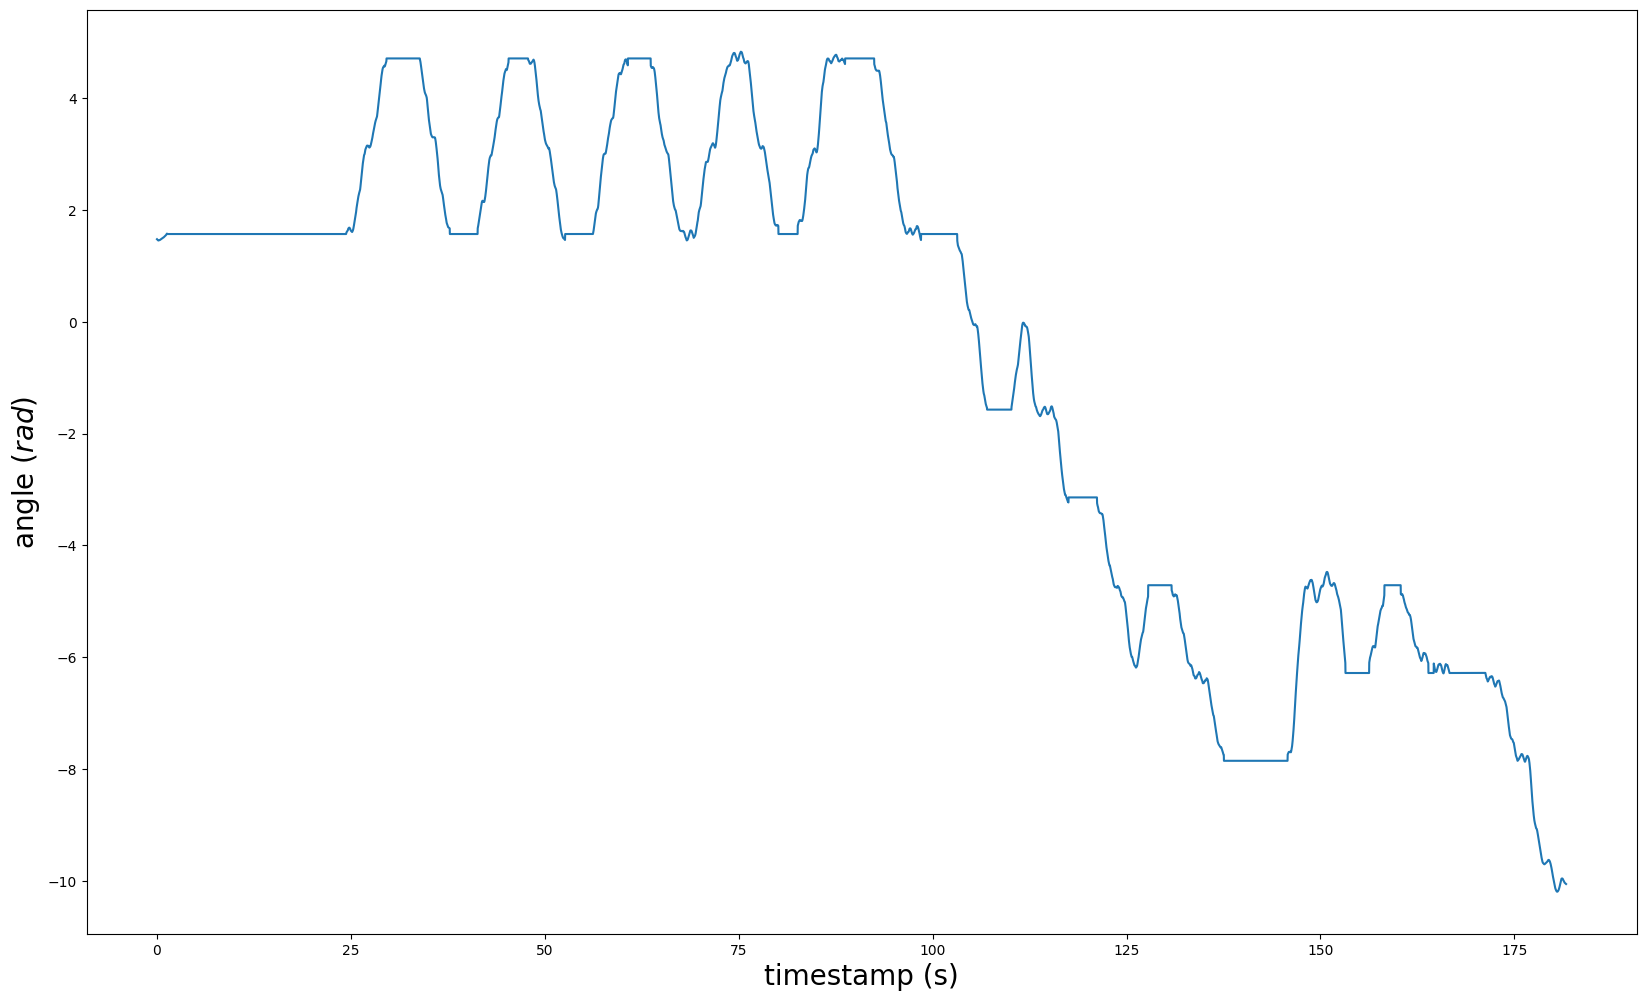

In [14]:
correct_angle_df = correct_angle(stable_angle_df, "x")

plt.plot(correct_angle_df.ts, correct_angle_df["x"])
plt.xlabel("timestamp (s)", fontsize=20)
plt.ylabel("angle ($rad$)", fontsize=20)
plt.show()

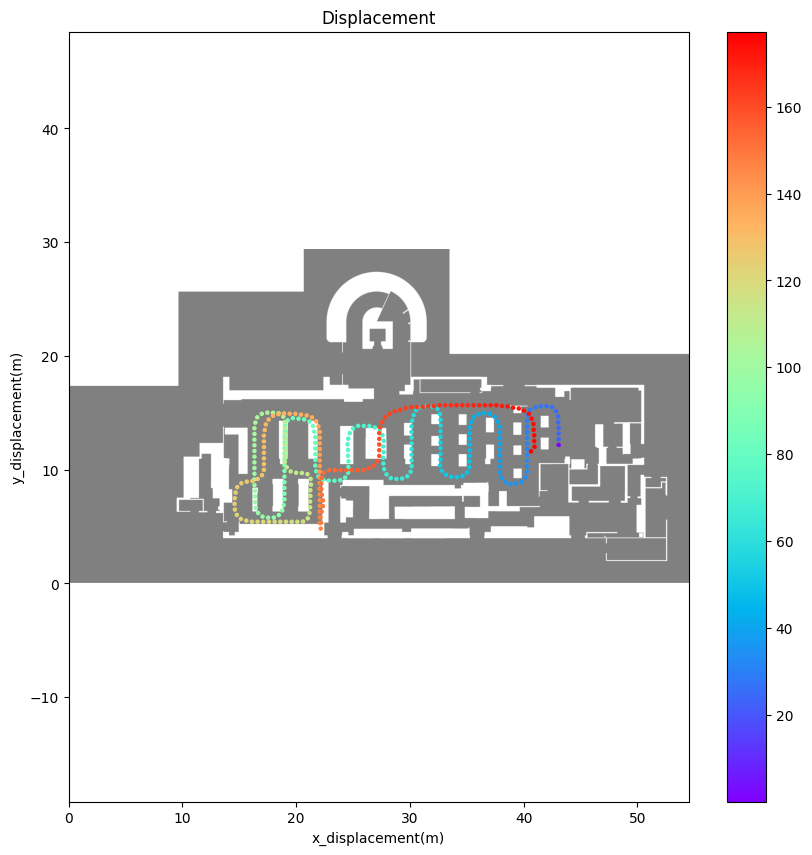

In [15]:
correct_angle_df_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        correct_angle_df,
        acc_df,
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["%time"][0],
    )
)

estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        correct_angle_df_displacement.x_displacement,
        correct_angle_df_displacement.y_displacement,
        c=correct_angle_df_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)


plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

In [16]:
def match_data(angle_df: pd.DataFrame, peek_t: pd.Series):
    matched_df = pd.DataFrame()
    for t in peek_t:
        matched_row = angle_df[np.isclose(angle_df["ts"], t, atol=0.005)]
        matched_df = pd.concat([matched_df, matched_row])
    return matched_df


def calculate_cumulative_displacement(
    ts: pd.Series,
    angle_data: pd.Series,
    step_length: float,
    initial_point: dict[str, float],
    initial_timestamp: float = 0.0,
):
    x_displacement = step_length * np.cos(angle_data["x"])
    y_displacement = step_length * np.sin(angle_data["x"])

    init_data_frame = pd.DataFrame(
        {
            "ts": [initial_timestamp],
            "x_displacement": initial_point["x"],
            "y_displacement": initial_point["y"],
            "stable_flag": angle_data["stable_flag"].values[0],
        },
    )

    return pd.concat(
        [
            init_data_frame,
            pd.DataFrame(
                {
                    "ts": ts,
                    "x_displacement": x_displacement.cumsum() + initial_point["x"],
                    "y_displacement": y_displacement.cumsum() + initial_point["y"],
                    "stable_flag": angle_data["stable_flag"],
                },
            ),
        ],
    )


def convert_to_peek_angle_and_compute_displacement_by_angle(
    angle: pd.DataFrame,
    acc: pd.DataFrame,
    peaks: np.ndarray,
    step_length: float,
    initial_point: dict[str, float],
    initial_timestamp: float = 0.0,
):
    # 歩行タイミング時の角度をmatch_data関数を用いて取得
    angle_in_step_timing = match_data(angle, acc.ts[peaks])

    # 累積変位を計算
    cumulative_displacement_df = calculate_cumulative_displacement(
        angle_in_step_timing.ts,
        angle_in_step_timing,
        step_length,
        initial_point,
        initial_timestamp,
    )

    return cumulative_displacement_df


correct_angle_df_displacement = convert_to_peek_angle_and_compute_displacement_by_angle(
    correct_angle_df,
    acc,
    peaks,
    0.5,
    {"x": gt_ref.x[0], "y": gt_ref.y[0]},
    gt_ref["%time"][0],
)

# stable_flagがtrueのもののみを描く
estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        correct_angle_df_displacement.x_displacement[
            correct_angle_df_displacement["stable_flag"]
        ],
        correct_angle_df_displacement.y_displacement[
            correct_angle_df_displacement["stable_flag"]
        ],
        c=correct_angle_df_displacement.ts[
            correct_angle_df_displacement["stable_flag"]
        ],
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

NameError: name 'acc' is not defined

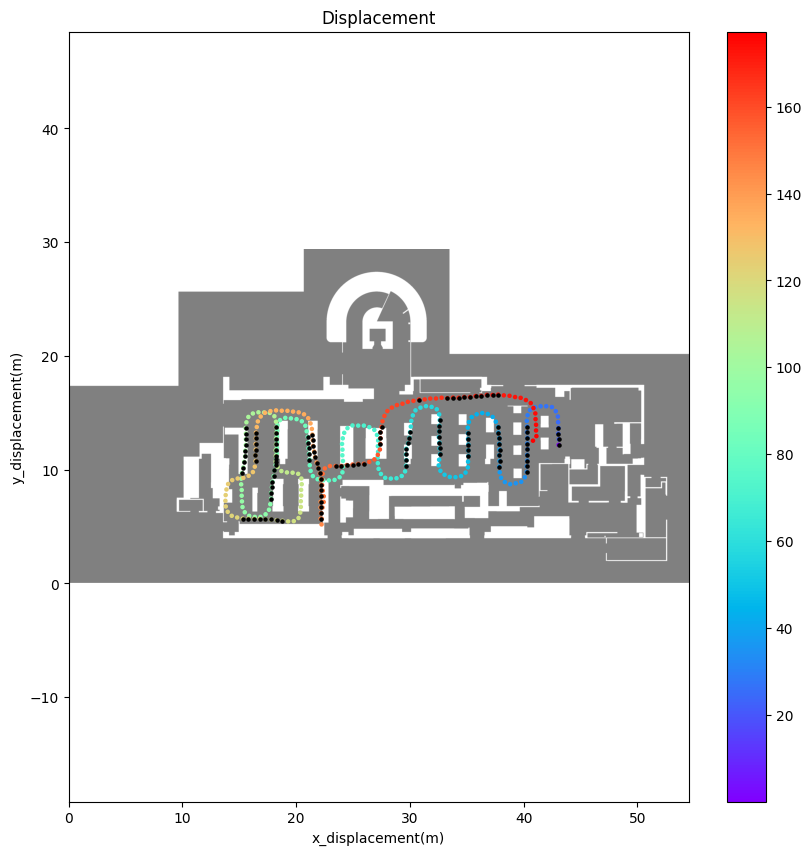

In [ ]:
# straight_angle_displacementにcorrect_angle_df_displacementのstable_flagを追加
straight_angle_displacement["stable_flag"] = correct_angle_df_displacement[
    "stable_flag"
]

estimate.plot_map(map_dict, floor_name, dx, dy)
# 普通に表示
plt.colorbar(
    plt.scatter(
        straight_angle_displacement.x_displacement,
        straight_angle_displacement.y_displacement,
        c=straight_angle_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)
# stable_flagがtrueのものは黒色で表示
plt.scatter(
    straight_angle_displacement.x_displacement[
        straight_angle_displacement["stable_flag"]
    ],
    straight_angle_displacement.y_displacement[
        straight_angle_displacement["stable_flag"]
    ],
    c="k",
    s=5,
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

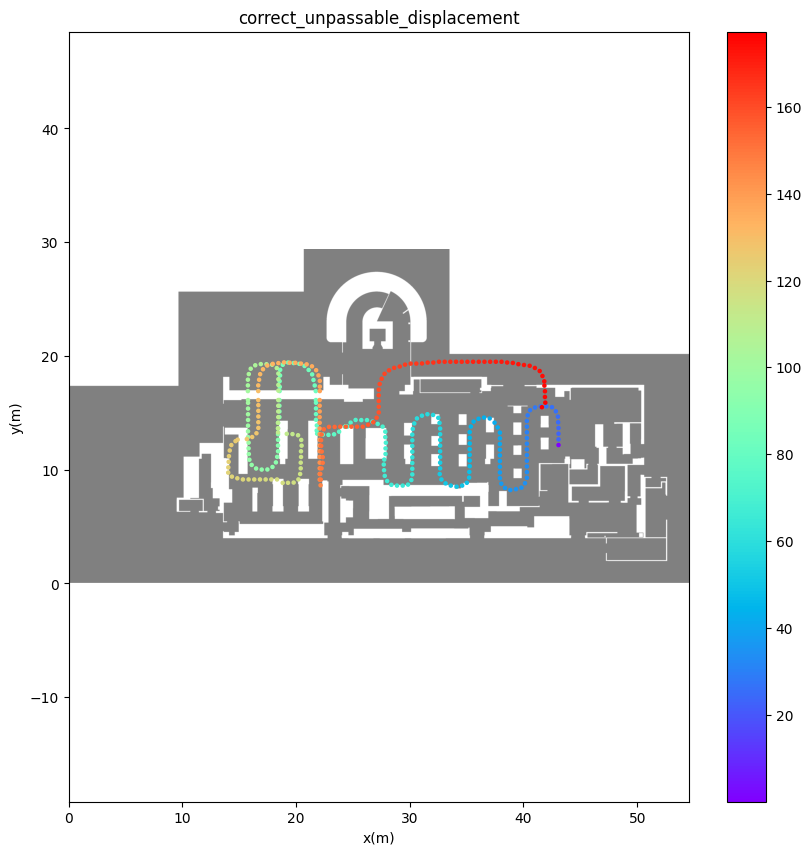

In [ ]:
# correct_unpassable_displacement = estimate.correct_unpassable_points(straight_angle_displacement, map_dict, floor_name, dx, dy)
correct_unpassable_displacement = estimate.correct_unpassable_points(
    correct_angle_df_displacement,
    map_dict,
    floor_name,
    dx,
    dy,
)


estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement["x_displacement"],
        correct_unpassable_displacement["y_displacement"],
        c=correct_unpassable_displacement["ts"],
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("correct_unpassable_displacement")
plt.show()


output_df = pd.DataFrame(
    {
        "timestamp": correct_unpassable_displacement["ts"],
        "x": correct_unpassable_displacement["x_displacement"],
        "y": correct_unpassable_displacement["y_displacement"],
        "floor": floor_name,
    },
)

output_df.to_csv("8_1_pdr_est.csv", index=False, header=False)